In [1]:
%pip install einops torch numpy matplotlib

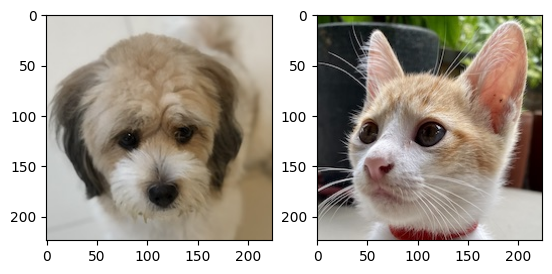

(0.0, 1.0, 0.0, 1.0)

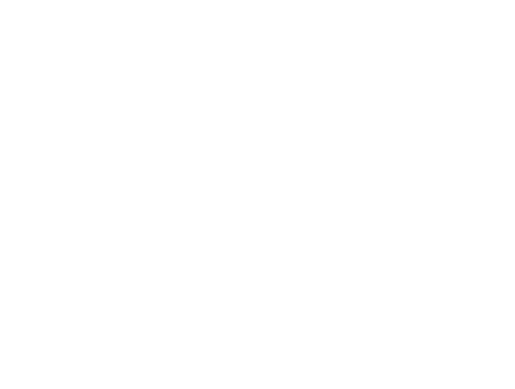

In [2]:
from einops import rearrange, reduce
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import image
import torch
from torch.nn import BatchNorm2d

aki_dog_original = image.imread('aki_dog.jpg')
wonder_cat_original = image.imread('wonder_cat.jpg')
fig, ax = plt.subplots(1,2)
ax[0].imshow(aki_dog_original)
ax[1].imshow(wonder_cat_original)
plt.show()
plt.axis('off')

# Implementation of Batch Normalization using `torch.nn.BatchNorm2d`


<ipython-input-3-f04baf9fc1ba>:2: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  aki_dog = torch.from_numpy(aki_dog_original).permute(2, 0, 1).unsqueeze(0).type(torch.FloatTensor)


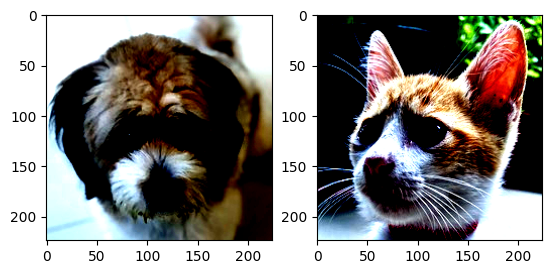

In [3]:
torch_results = []
aki_dog = torch.from_numpy(aki_dog_original).permute(2, 0, 1).unsqueeze(0).type(torch.FloatTensor)
wonder_cat = torch.from_numpy(wonder_cat_original).permute(2, 0, 1).unsqueeze(0).type(torch.FloatTensor)

# Stack both images along the batch dimension (axis 0)
batch_images = torch.cat([aki_dog, wonder_cat], dim=0)

# Apply Batch Normalization to the batch
normalizer = BatchNorm2d(3, affine=False)
batch_output = normalizer(batch_images)

fig, ax = plt.subplots(1,2)
# Convert the output back to images for both
for i in range(batch_output.shape[0]):
    # Clip the output to the valid range [0, 1]
    torch_bn2d_to_numpy = batch_output[i].permute(1, 2, 0).numpy()
    torch_bn2d_to_numpy = np.uint8(np.clip(torch_bn2d_to_numpy, 0, 1) * 255)  # Clip to [0, 1]
    torch_results.append(torch_bn2d_to_numpy)

    # Convert back to 8-bit values and display the image
    torch_bn2d_to_numpy_img = ax[i].imshow(torch_bn2d_to_numpy)

plt.show()

# Implementation of Batch Normalization using `einops`

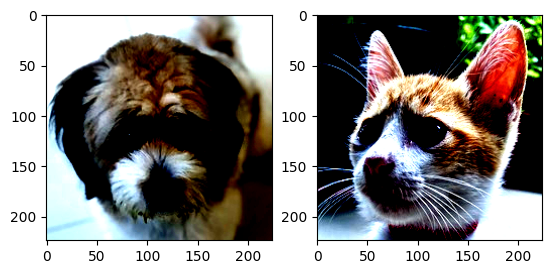

In [4]:
einops_results = []

# Rearrange dimensions for both images and stack them to create a batch
aki_dog = rearrange(aki_dog_original.astype(float), 'h w c -> 1 c h w')  # Convert to batch format
wonder_cat = rearrange(wonder_cat_original.astype(float), 'h w c -> 1 c h w')

# Stack both images along the batch dimension (axis 0)
batch_images = np.concatenate([aki_dog, wonder_cat], axis=0)  # Shape: (2, c, h, w)

# Compute mean and variance per channel across the batch (like BatchNorm2d)
MEAN = reduce(batch_images, 'b c h w -> c () ()', 'mean')  # Single mean across batch
variance = reduce((batch_images - MEAN) ** 2, 'b c h w -> c () ()', 'mean')  # Single variance across batch
standard_dev = variance ** 0.5

# Normalize the images
normalized_batch = (batch_images - MEAN) / (standard_dev + 1e-5)

fig, ax = plt.subplots(1,2)

# Avoid clipping or rescaling manually
# Now, convert back to image format for each image in the batch
for n in range(normalized_batch.shape[0]):
    normalized_image = rearrange(normalized_batch[n], 'c h w -> h w c')  # Rearrange to HWC format

    # Convert back to the original scale [0, 255] for viewing
    for i in range(len(normalized_image)):
        for j in range(len(normalized_image[i])):
            for k in range(len(normalized_image[i][j])):
                normalized_image[i][j][k] = min(1.0, max(0.0, normalized_image[i][j][k]))

    normalized_image = np.array(normalized_image * 255, dtype=np.uint8) # just making sure we're using the right format of int for numpy
    einops_results.append(normalized_image)

    # Convert to PIL image and save or display
    normalized_image_pil = ax[n].imshow(normalized_image)

plt.show()

# Validation

In [5]:
for i in range(2):
  are_outputs_close = np.allclose(torch_results[i], einops_results[i])
  print(f'Results close for image {i}? {are_outputs_close}')
  if not are_outputs_close:
    print("Max difference:", np.max(np.abs(torch_results[i] - einops_results[i])))

Results close for image 0? True
Results close for image 1? True
